In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 3.8 MB/s 
     |████████████████████████████████| 1.3 MB 68.6 MB/s 
     |████████████████████████████████| 5.3 MB 67.7 MB/s 
     |████████████████████████████████| 432 kB 80.9 MB/s 
     |████████████████████████████████| 212 kB 84.8 MB/s 
     |████████████████████████████████| 115 kB 86.0 MB/s 
     |████████████████████████████████| 163 kB 94.0 MB/s 
     |████████████████████████████████| 127 kB 85.0 MB/s 
     |████████████████████████████████| 7.6 MB 54.3 MB/s 
Mounted at /content/gdrive


In [ ]:
!pip install timm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 3.8 MB/s 


In [ ]:
from fastbook import *
import timm
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer

In [ ]:
path = Path('/content/gdrive/MyDrive/OASIS')

In [ ]:
path.ls()

(#6) [Path('/content/gdrive/MyDrive/OASIS/OASIS_PNG'),Path('/content/gdrive/MyDrive/OASIS/Binary_DenseNet161_Train.pth'),Path('/content/gdrive/MyDrive/OASIS/Binary_DenseNet161_TrainExp.pkl'),Path('/content/gdrive/MyDrive/OASIS/Binary_ResNet34_Train.pth'),Path('/content/gdrive/MyDrive/OASIS/Binary_ResNet34TrainExp.pkl'),Path('/content/gdrive/MyDrive/OASIS/Test')]

In [ ]:
item_tfms = Resize(256)
batch_tfms = aug_transforms=[Normalize.from_stats(*imagenet_stats)]

In [ ]:
train_fnames=get_image_files(path/'OASIS_PNG')

In [ ]:
dblock=DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items= get_image_files,
                  get_y = parent_label,
                  splitter =RandomSplitter(valid_pct= 0.2),
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms
                  )

In [ ]:
dls = dblock.dataloaders(path,bs=32)

In [ ]:
dls.c,len(dls.train_ds),len(dls.valid_ds)

(2, 16971, 4242)

In [ ]:
dls.vocab

['CN', 'MILD']

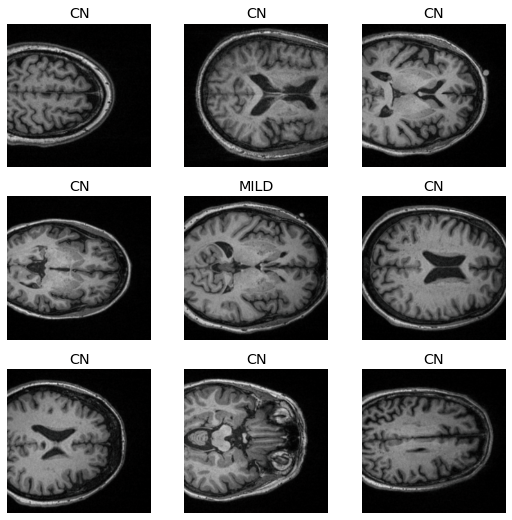

In [ ]:
dls.show_batch()


In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [ ]:
body = create_timm_body('resnet34', pretrained=True)


In [ ]:
nf = num_features_model(nn.Sequential(*body.children())); nf


512

In [ ]:
model = nn.Sequential(body,create_head(nf=512, n_out=2))


In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)


SuggestedLRs(valley=0.007585775572806597)

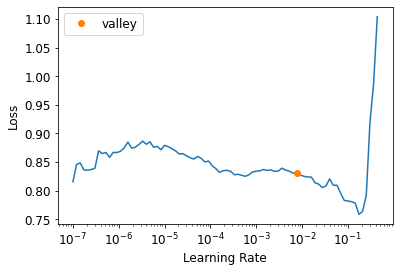

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(20,0.85e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.509709,0.360682,0.884017,26:46


epoch,train_loss,valid_loss,accuracy,time
0,0.368296,0.396098,0.886139,02:50
1,0.374861,0.998364,0.884017,02:50
2,0.350332,0.334174,0.884017,02:50
3,0.374448,4.068514,0.884017,02:50
4,0.318959,0.545713,0.883781,02:50
5,0.323374,0.394742,0.884960,02:50
6,0.317371,0.292862,0.894154,02:51
7,0.282467,0.270567,0.899811,02:51
8,0.202717,0.235635,0.918199,02:51
9,0.176600,0.175528,0.934229,02:51


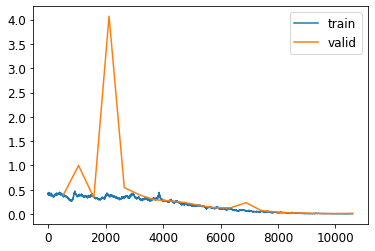

In [ ]:
learn.recorder.plot_loss()

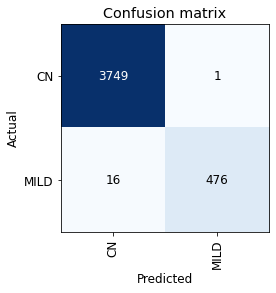

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
print("Number of examples in testing:", len(dls.valid_ds))


Number of examples in testing: 4242


In [ ]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9966996908187866

In [ ]:
interp.most_confused()


[('MILD', 'CN', 16), ('CN', 'MILD', 1)]

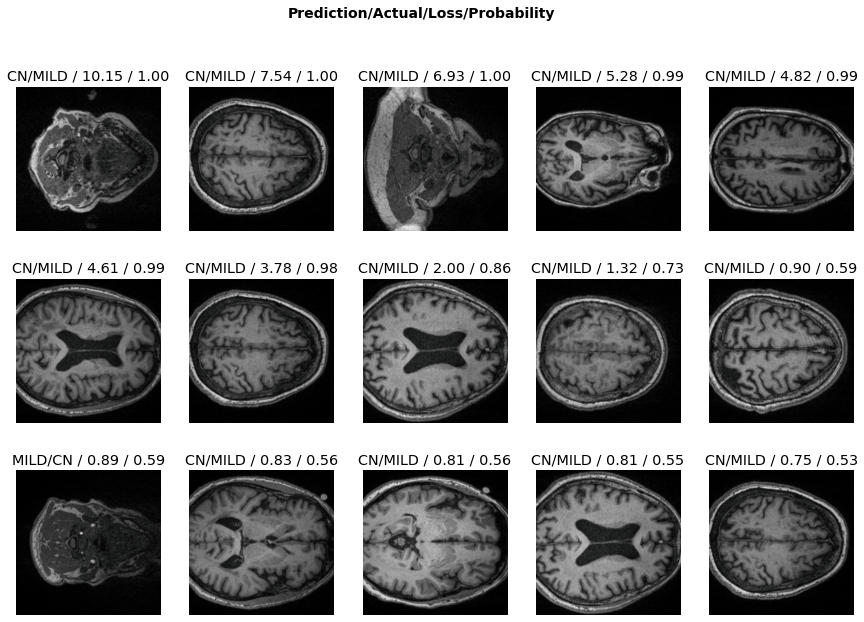

In [ ]:
interp.plot_top_losses(15, figsize=(15,10))

In [ ]:
interp.print_classification_report()


              precision    recall  f1-score   support

          CN       1.00      1.00      1.00      3750
        MILD       1.00      0.97      0.98       492

    accuracy                           1.00      4242
   macro avg       1.00      0.98      0.99      4242
weighted avg       1.00      1.00      1.00      4242



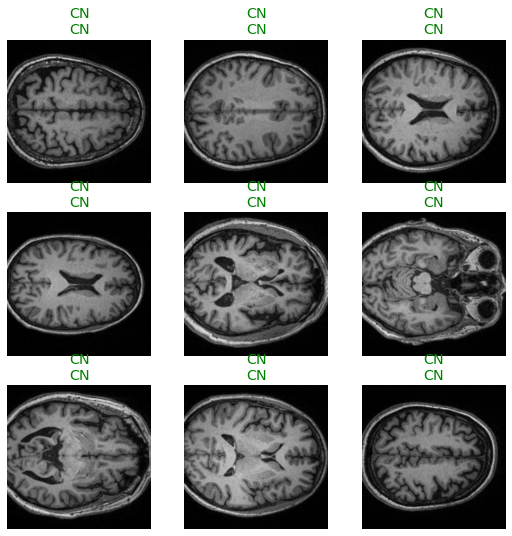

In [ ]:
learn.show_results()


In [ ]:
learn.save(path/'CNMILD_ResNet34_Train')


Path('/content/gdrive/MyDrive/OASIS/CNMILD_ResNet34_Train.pth')

In [ ]:
learn.export(path/'Binary_ResNet34TrainExp.pkl')

In [ ]:
all_files= get_image_files(path)

In [ ]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=GrandparentSplitter(train_name='OASIS_PNG', valid_name='Test'),
                 get_y=parent_label,
                 item_tfms=Resize(512,method='squish'),
                 batch_tfms=Normalize.from_stats(*imagenet_stats)
                 
                 
)

In [ ]:
dls_test = dblock.dataloaders(all_files)

In [ ]:
print("Number of examples in testing:", len(dls_test.valid_ds))

Number of examples in testing: 1685


In [ ]:
learn1 = learn = Learner(dls_test, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load('/content/gdrive/MyDrive/OASIS/CNMILD_ResNet34_Train')

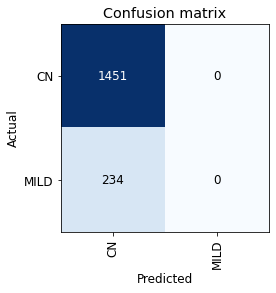

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

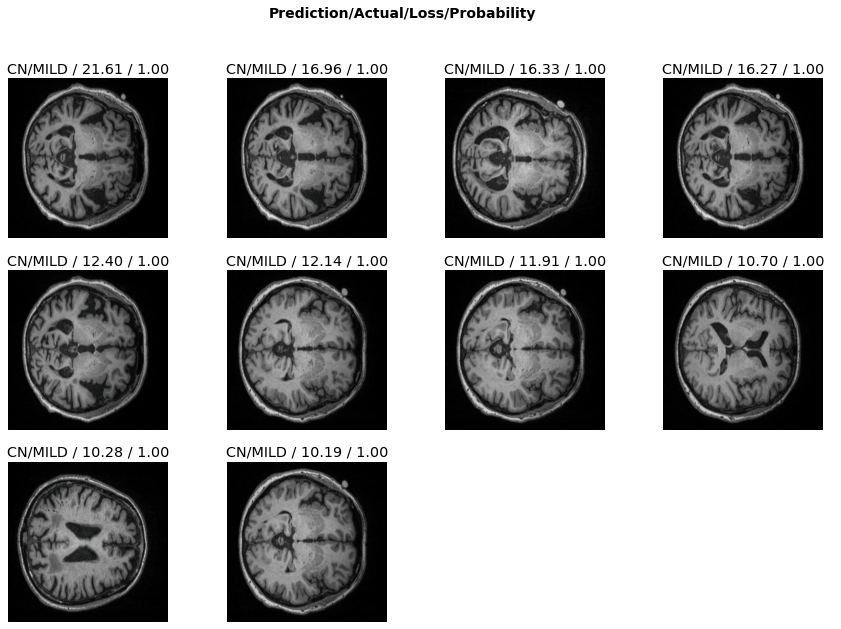

In [ ]:
interp.plot_top_losses(10, figsize=(15,10))


In [ ]:
interp.print_classification_report()


              precision    recall  f1-score   support

          CN       0.86      1.00      0.93      1451
        MILD       0.00      0.00      0.00       234

    accuracy                           0.86      1685
   macro avg       0.43      0.50      0.46      1685
weighted avg       0.74      0.86      0.80      1685



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
